In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [2]:
cont_names = [
    "Elevation",
    "Aspect",
    "Slope",
    "R_Hydrology",
    "Z_Hydrology",
    "R_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "R_Fire_Points",

]
cont_dict = {name: np.float64 for name in cont_names}
area_names = ['WArea_' + str(i + 1) for i in range(4)]
area_dict = {name: np.int64 for name in area_names}
soil_names = ['Soil_' + str(i + 1) for i in range(40)]
soil_dict = {name: np.int64 for name in soil_names}
cat_names = area_names + soil_names # Categorical variables

target = 'Cover_Type'

names = cont_names + cat_names # All column names except target
dtypes_dict = {**cont_dict, **area_dict, **soil_dict}

In [69]:
df = pd.read_csv('/content/forest_dataset.csv',header=0,names=names + [target], dtype=dtypes_dict)
df.head()

,Elevation,Aspect,Slope,R_Hydrology,Z_Hydrology,R_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,R_Fire_Points,...,Soil_32,Soil_33,Soil_34,Soil_35,Soil_36,Soil_37,Soil_38,Soil_39,Soil_40,Cover_Type
0,2683.0,333.0,35.0,30.0,26.0,2743.0,121.0,173.0,179.0,6572.0,...,0,0,0,0,0,0,0,0,0,2
1,2915.0,90.0,8.0,216.0,11.0,4433.0,232.0,228.0,129.0,4019.0,...,0,0,0,0,0,0,0,0,0,1
2,2941.0,162.0,7.0,698.0,76.0,2783.0,227.0,242.0,148.0,1784.0,...,0,0,0,0,0,0,0,0,0,2
3,3096.0,60.0,17.0,170.0,3.0,3303.0,231.0,202.0,99.0,5370.0,...,0,0,0,0,0,0,0,0,0,1
4,2999.0,66.0,8.0,488.0,37.0,1532.0,228.0,225.0,131.0,2290.0,...,0,0,0,0,0,0,0,0,0,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Elevation       10000 non-null  float64
 1   Aspect          10000 non-null  float64
 2   Slope           10000 non-null  float64
 3   R_Hydrology     10000 non-null  float64
 4   Z_Hydrology     10000 non-null  float64
 5   R_Roadways      10000 non-null  float64
 6   Hillshade_9am   10000 non-null  float64
 7   Hillshade_Noon  10000 non-null  float64
 8   Hillshade_3pm   10000 non-null  float64
 9   R_Fire_Points   10000 non-null  float64
 10  WArea_1         10000 non-null  int64  
 11  WArea_2         10000 non-null  int64  
 12  WArea_3         10000 non-null  int64  
 13  WArea_4         10000 non-null  int64  
 14  Soil_1          10000 non-null  int64  
 15  Soil_2          10000 non-null  int64  
 16  Soil_3          10000 non-null  int64  
 17  Soil_4          10000 non-null  

In [5]:
df.describe()

,Elevation,Aspect,Slope,R_Hydrology,Z_Hydrology,R_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,R_Fire_Points,...,Soil_32,Soil_33,Soil_34,Soil_35,Soil_36,Soil_37,Soil_38,Soil_39,Soil_40,Cover_Type
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,2960.645900,154.127600,13.98120,269.502800,45.596800,2358.805400,212.382200,223.886000,142.892300,1982.005000,...,0.092300,0.078300,0.002000,0.002900,0.000300,0.000500,0.024000,0.02130,0.012300,2.034100
std,276.101899,111.112044,7.44313,214.741609,57.607363,1564.814207,26.560675,19.443395,37.460182,1307.685368,...,0.289463,0.268657,0.044679,0.053776,0.017319,0.022356,0.153057,0.14439,0.110227,1.378016
min,1866.000000,0.000000,0.00000,0.000000,-147.000000,0.000000,70.000000,88.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,2819.000000,57.000000,9.00000,108.000000,6.000000,1106.750000,199.000000,213.000000,120.000000,1041.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
50%,2996.000000,128.000000,13.00000,218.000000,29.000000,2008.000000,218.000000,227.000000,143.000000,1719.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000
75%,3162.000000,254.000000,18.00000,390.000000,68.000000,3330.250000,231.000000,238.000000,167.000000,2542.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000
max,3846.000000,359.000000,57.00000,1370.000000,573.000000,7023.000000,254.000000,254.000000,247.000000,7080.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,7.000000


In [70]:
x=df.drop('Cover_Type',axis=1)
y=df['Cover_Type']

In [7]:
x.shape

(10000, 54)

In [8]:
y.shape

(10000,)

In [71]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [10]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 54)
(2000, 54)
(8000,)
(2000,)


In [72]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [12]:
model=LogisticRegression(max_iter=100,multi_class='ovr')
model.fit(x_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr')

In [13]:
model.score(x_train,y_train)

0.71175

In [14]:
model.score(x_test,y_test)

0.715

In [15]:
y_pred=model.predict(x_test)
print(y_pred)

[1 1 2 ... 2 2 3]


In [16]:
print(y_pred)
print(y_test)

[1 1 2 ... 2 2 3]
9394    1
898     1
2398    2
5906    2
2343    2
       ..
1037    2
2899    2
9549    2
2740    2
6690    3
Name: Cover_Type, Length: 2000, dtype: int64


In [17]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[512 206   0   0   0   0   8]
 [183 771  30   0   3   2   2]
 [  0  15 100   3   0   6   0]
 [  0   0   4   4   0   1   0]
 [  0  24   3   0   0   0   0]
 [  0  15  25   0   0   8   0]
 [ 40   0   0   0   0   0  35]]


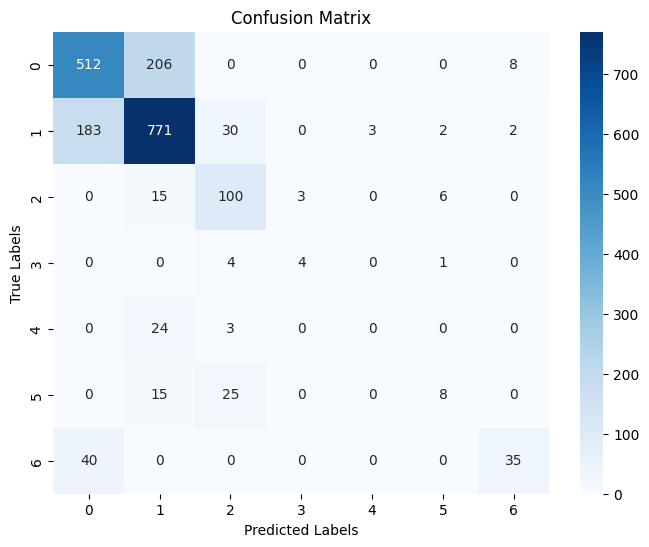

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.70      0.71      0.70       726
           2       0.75      0.78      0.76       991
           3       0.62      0.81      0.70       124
           4       0.57      0.44      0.50         9
           5       0.00      0.00      0.00        27
           6       0.47      0.17      0.25        48
           7       0.78      0.47      0.58        75

    accuracy                           0.71      2000
   macro avg       0.55      0.48      0.50      2000
weighted avg       0.70      0.71      0.71      2000



In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.715


In [21]:
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Precision: 0.7047127708905884
Recall: 0.715
F1 Score: 0.7056862208513036


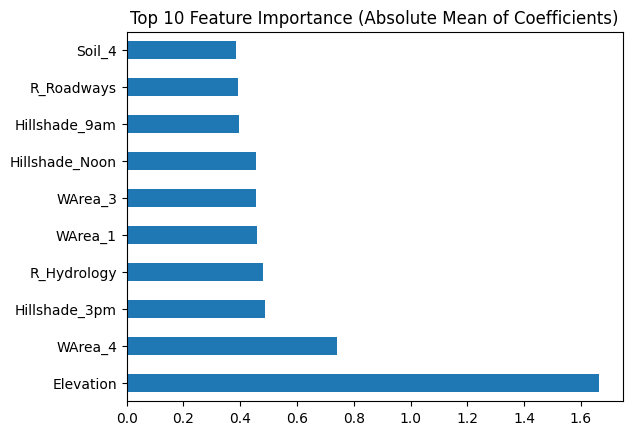

In [22]:
feature_importance = pd.Series(np.abs(model.coef_).mean(axis=0), index=x.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importance (Absolute Mean of Coefficients)")
plt.show()

In [28]:
dt_model=DecisionTreeClassifier()
dt_model.fit(x_train,y_train)

DecisionTreeClassifier()

In [29]:
dt_model.score(x_train,y_train)

1.0

In [30]:
dt_model.score(x_test,y_test)

0.7295

In [31]:
y_pred=dt_model.predict(x_test)
print(y_pred)

[1 2 1 ... 2 2 6]


In [38]:
print(y_pred)
print(y_test)

[1 2 1 ... 2 2 6]
9394    1
898     1
2398    2
5906    2
2343    2
       ..
1037    2
2899    2
9549    2
2740    2
6690    3
Name: Cover_Type, Length: 2000, dtype: int64


In [33]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[504 199   2   0   2   1  18]
 [179 776  14   0  10   9   3]
 [  0  13  81   2   1  27   0]
 [  0   0   5   3   0   1   0]
 [  2  12   1   0  12   0   0]
 [  0   7  12   1   0  28   0]
 [ 18   2   0   0   0   0  55]]


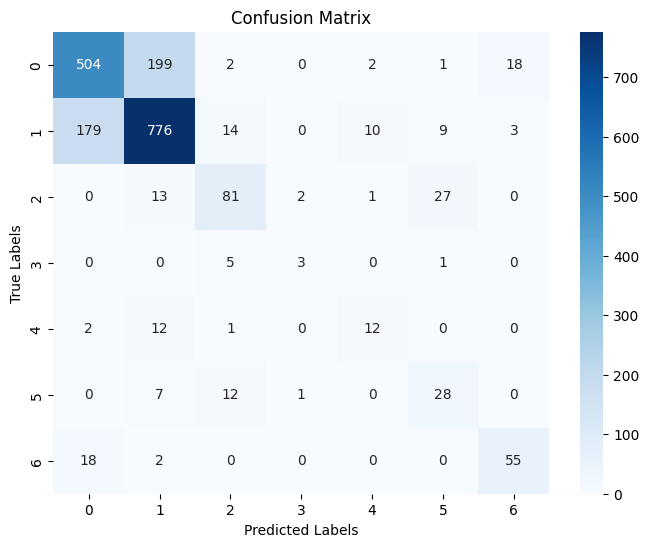

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.72      0.69      0.71       726
           2       0.77      0.78      0.78       991
           3       0.70      0.65      0.68       124
           4       0.50      0.33      0.40         9
           5       0.48      0.44      0.46        27
           6       0.42      0.58      0.49        48
           7       0.72      0.73      0.73        75

    accuracy                           0.73      2000
   macro avg       0.62      0.60      0.61      2000
weighted avg       0.73      0.73      0.73      2000



In [36]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7295


In [37]:
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("feature importance:",dt_model.feature_importances_)

Precision: 0.7310425023542191
Recall: 0.7295
F1 Score: 0.7297272115172307
feature importance: [3.37581096e-01 3.90597925e-02 4.00713230e-02 7.41138445e-02
 5.75692997e-02 1.05096344e-01 4.34613245e-02 4.45449674e-02
 4.14890431e-02 9.82612357e-02 6.39306809e-03 5.56673468e-03
 5.97745750e-03 2.86287202e-03 1.78872018e-04 1.03026600e-02
 2.87822538e-03 1.05101257e-02 9.51478888e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.49735121e-03
 1.98190185e-03 8.34949029e-04 1.77476088e-03 0.00000000e+00
 0.00000000e+00 7.08099882e-04 0.00000000e+00 0.00000000e+00
 3.51897845e-04 2.35688766e-03 0.00000000e+00 1.24241182e-02
 9.14817390e-03 3.33044084e-03 0.00000000e+00 0.00000000e+00
 1.30894879e-03 0.00000000e+00 5.02823191e-03 1.34102416e-03
 5.35654041e-03 1.04475332e-02 4.95152330e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.43949587e-03
 2.81485551e-03 2.03350166e-03]


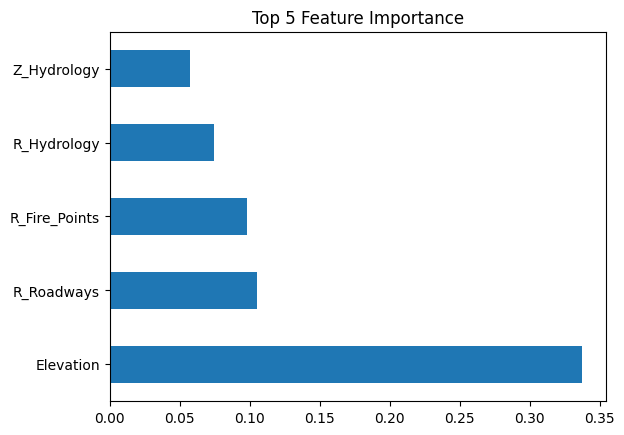

In [40]:
feature_importance = pd.Series(dt_model.feature_importances_,index=x.columns)
feature_importance.nlargest(5).plot(kind='barh')
plt.title("Top 5 Feature Importance")
plt.show()

#Bonus:
#Random Forest
#xgboost
#Hyperparameter Tuning

In [73]:
rf_model=RandomForestClassifier()
rf_model.fit(x_train,y_train)

RandomForestClassifier()

In [46]:
rf_model.score(x_train,y_train)

1.0

In [47]:
rf_model.score(x_test,y_test)

0.8025

In [75]:
y_pred=rf_model.predict(x_test)
print(y_pred)

[1 1 2 ... 2 1 3]


In [49]:
print(y_pred)
print(y_test)

[1 1 2 ... 2 1 3]
9394    1
898     1
2398    2
5906    2
2343    2
       ..
1037    2
2899    2
9549    2
2740    2
6690    3
Name: Cover_Type, Length: 2000, dtype: int64


In [50]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[576 146   0   0   0   0   4]
 [131 849   5   0   1   4   1]
 [  1  13 102   0   0   8   0]
 [  0   0   5   2   0   2   0]
 [  1  19   1   0   6   0   0]
 [  0   7  20   0   0  21   0]
 [ 25   1   0   0   0   0  49]]


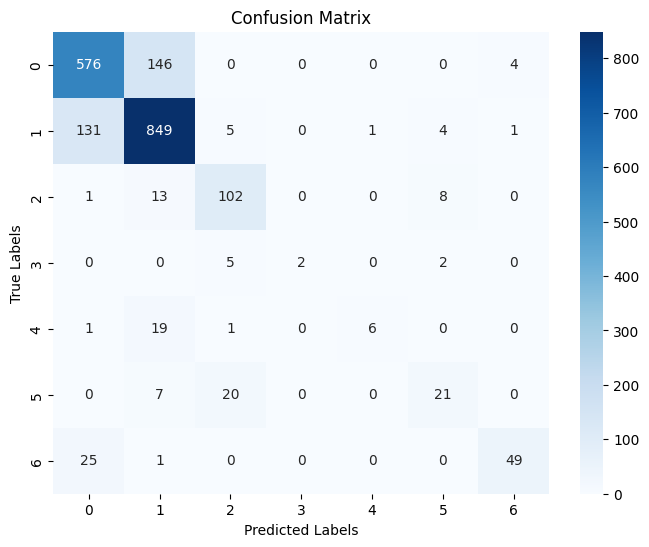

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [52]:
print("classification report",classification_report(y_test,y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("feature importance:",rf_model.feature_importances_)

classification report               precision    recall  f1-score   support

           1       0.78      0.79      0.79       726
           2       0.82      0.86      0.84       991
           3       0.77      0.82      0.79       124
           4       1.00      0.22      0.36         9
           5       0.86      0.22      0.35        27
           6       0.60      0.44      0.51        48
           7       0.91      0.65      0.76        75

    accuracy                           0.80      2000
   macro avg       0.82      0.57      0.63      2000
weighted avg       0.80      0.80      0.80      2000

Accuracy: 0.8025
Precision: 0.8033627371404066
Recall: 0.8025
F1 Score: 0.797950794478788
feature importance: [2.33929361e-01 6.22023066e-02 4.80972489e-02 6.37882074e-02
 6.19232896e-02 8.81439073e-02 5.48815242e-02 5.81536256e-02
 5.63111305e-02 8.23808057e-02 1.06497336e-02 4.29493742e-03
 1.04435415e-02 2.70744906e-02 1.55673647e-03 9.31344170e-03
 2.37067055e-03 9.29044865e

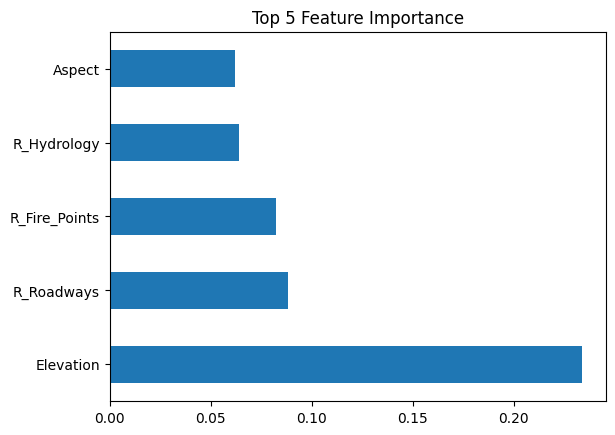

In [53]:
feature_importance = pd.Series(rf_model.feature_importances_,index=x.columns)
feature_importance.nlargest(5).plot(kind='barh')
plt.title("Top 5 Feature Importance")
plt.show()

In [77]:
#Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid=GridSearchCV(estimator=rf_model,param_grid=param_grid,scoring='accuracy',cv=3,n_jobs=-1)
grid=grid.fit(x_train,y_train)
print("best params",grid.best_params_)
print("best params", grid.best_score_)

best params {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
best params 0.7831249150870394


In [60]:
xg_model=xgb.XGBClassifier()
xg_model.fit(x_train,y_train - 1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [61]:
xg_model.score(x_train,y_train - 1)

0.97675

In [62]:
xg_model.score(x_test,y_test - 1)

0.7985

In [63]:
y_pred=xg_model.predict(x_test)
print(y_pred)

[0 0 1 ... 1 1 5]


In [64]:
print(y_pred)
print(y_test - 1)

[0 0 1 ... 1 1 5]
9394    0
898     0
2398    1
5906    1
2343    1
       ..
1037    1
2899    1
9549    1
2740    1
6690    2
Name: Cover_Type, Length: 2000, dtype: int64


In [65]:
cm=confusion_matrix(y_test - 1,y_pred)
print(cm)

[[568 155   0   0   0   0   3]
 [135 844   7   0   2   3   0]
 [  0  17  92   2   0  13   0]
 [  0   0   4   3   0   2   0]
 [  0  17   1   0   9   0   0]
 [  0   7  14   0   0  27   0]
 [ 19   2   0   0   0   0  54]]


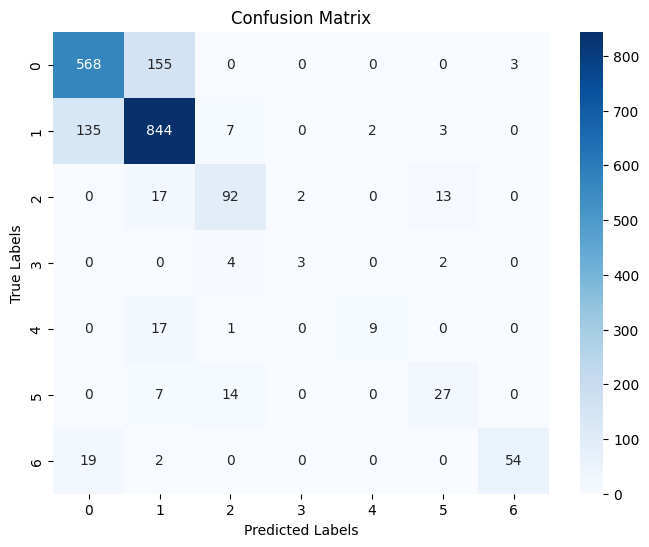

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [67]:
print("classification report",classification_report(y_test - 1,y_pred))
print("Accuracy:", accuracy_score(y_test - 1, y_pred))
print("Precision:", precision_score(y_test - 1, y_pred, average='weighted'))
print("Recall:", recall_score(y_test - 1, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test - 1, y_pred, average='weighted'))
print("feature importance:",xg_model.feature_importances_)

classification report               precision    recall  f1-score   support

           0       0.79      0.78      0.78       726
           1       0.81      0.85      0.83       991
           2       0.78      0.74      0.76       124
           3       0.60      0.33      0.43         9
           4       0.82      0.33      0.47        27
           5       0.60      0.56      0.58        48
           6       0.95      0.72      0.82        75

    accuracy                           0.80      2000
   macro avg       0.76      0.62      0.67      2000
weighted avg       0.80      0.80      0.80      2000

Accuracy: 0.7985
Precision: 0.7989296500313698
Recall: 0.7985
F1 Score: 0.7962793109508196
feature importance: [0.0832747  0.01016487 0.00892342 0.01466575 0.01155879 0.01584886
 0.01126039 0.01407812 0.00857128 0.01521991 0.04414761 0.02495507
 0.02438718 0.01277301 0.00570961 0.04987873 0.01263762 0.03341847
 0.00852676 0.00436519 0.         0.00774463 0.01092168 0.02205316
 0

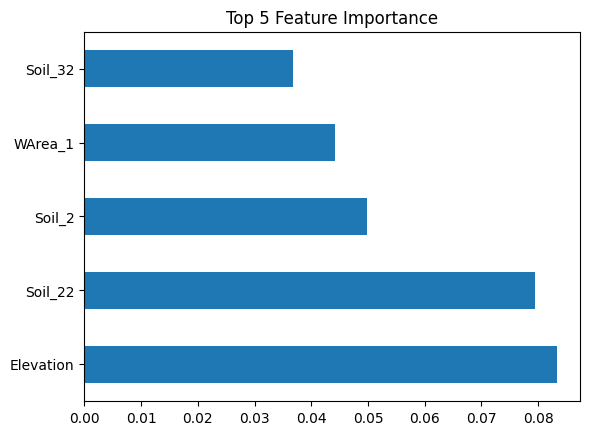

In [68]:
feature_importance = pd.Series(xg_model.feature_importances_,index=x.columns)
feature_importance.nlargest(5).plot(kind='barh')
plt.title("Top 5 Feature Importance")
plt.show()